# Poset Multiline Queues

## General packages

In [16]:
import itertools 
import copy
from sage.combinat.q_analogues import *
from sage.combinat.sf.sf import *
from sage.combinat.ncsf_qsym.qsym import *
from sage.rings.rational_field import *
from sage.combinat.subset import *
from sage.combinat.permutation import *
from sage.misc.latex import *

import sage.combinat.permutation as permutation
from sage.combinat.sf.macdonald import qt_kostka
from sage.combinat.sf.ns_macdonald import E
from sage.rings.polynomial.polydict import ETuple

coeffs_ring = ZZ['q','t']

q = coeffs_ring.gens()[0]
t = coeffs_ring.gens()[1]

coeffs_field = coeffs_ring.fraction_field()
R=PolynomialRing(coeffs_field,11,'x')
xs=list(R.gens())

sym = SymmetricFunctions(coeffs_field)
h = sym.homogeneous()
m = sym.monomial()
s = sym.schur()
e = sym.elementary()
p = sym.power()
Ht = sym.macdonald().Ht()
H = sym.macdonald().H()
W = sym.macdonald(t=0).P()
S = sym.macdonald(q=0).S()

MJ = sym.macdonald().J()
HLP = sym.hall_littlewood(t).P()
HLQ = sym.hall_littlewood(t).Q();
HLQp = sym.hall_littlewood(t).Qp();
JJ = sym.jack().J()
qsym = QuasiSymmetricFunctions(coeffs_field)
F = qsym.Fundamental()
M = qsym.Monomial()
QS = qsym.QS()
YQS = qsym.YQS()

%display latex

### Posets

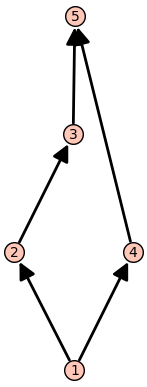

[[], [1], [1, 2], [1, 2, 3], [1, 2, 3, 5], [1, 2, 5], [1, 3], [1, 3, 5], [1, 4], [1, 4, 5], [1, 5], [2], [2, 3], [2, 3, 5], [2, 5], [3], [3, 5], [4], [4, 5], [5]]


In [2]:
##  Definition of a poset  ##

#elms = [1,2,3,4]
#rels = [[1,2],[1,3],[2,4],[3,4]]

elms = [1,2,3,4,5]
#rels = [[1,2],[1,3],[1,4],[2,5],[3,5],[4,5]]
rels = [[1,2],[2,3],[3,5],[1,4],[4,5]]


P = Poset((elms, rels), cover_relations = True)


##  Hasse diagrams  ##

H = P.hasse_diagram()
#H.plot(layout = 'acyclic')
H.show(layout = 'acyclic')


##  Comparing elements  ##

#print(P.is_less_than(2,3))
#print(P.is_less_than(1,4))
#print(P(2) <= P(4))


##  Chains  ##

#print(list(P.chains()))
#print(list(P.,maximal_chains()))


##  Linear extensions  ##

#print(list(P.linear_extensions()))


##  idk  ##

print(list(P.chains()))

## Poset Tableaux

In [3]:
# Gives the set of multichains of a poset P of size L

def multichains(P,L):
    C = list(P.chains())
    N = P.cardinality()
    
    multichains = []
    
    for c in C:
        mults = [comp for comp in Compositions(L) if len(comp) == len(c)]
        for m in mults:
            multi = []
            for j in range(len(m)):
                multi += [c[j] for k in range(m[j])]
            multichains.append(multi)
    
    return(multichains)


# Decides if a given array arr (of partition shape) is a P-tableau

def is_P_tableau(P,arr):
    ans = True
    
    for l in range(1,len(arr)):
        cant = len(arr[l])
        for i in range(cant):
            a = arr[l-1][i]
            b = arr[l][i]
            
            #Version1: incomparable elements can be in the same column
            #if (P.is_less_than(b,a) or P(a) == P(b)):
                
            #Version2: columns are chains
            if (not P.is_less_than(a,b)):
                ans = False
                break
                
        if(not ans):
            break
            
    return(ans)
    


# For a poset P, gives the set of P-tableaux of shape lam 

def PosetTableaux(P,lam):
    n = P.cardinality()
    nums = list(range(1,n+1))
    
    # Construct the arrays of numbers with multichains in rows
    
    parts = [[] for i in range(len(lam))]
    for j in range(len(lam)):
        parts[j] = multichains(P,lam[j])
    
    P_arrays = list(itertools.product(*parts))
    
    #print(P_arrays)
    
    # Verify which arrays are a P-tableau
    
    P_tab = []
    
    for arr in P_arrays:
        if is_P_tableau(P,arr):
            #print(arr)
            P_tab.append(arr)
            
            
    # Construct the arrays of numbers with chains in columns
    
    return(P_tab)


# Returns the x-weigth of a tableau

def tab_x_weight(T,xs):
    w = 1
    
    for i in range(len(T)):
        row = T[i]
        for j in range(len(row)):
            num = row[j]
            w *= xs[num-1]
    return(w)
    
# Computes the Poset Schur Function of shape lam

def PosetSchur(P,lam):
    Ptab = PosetTableaux(P,lam)
    N = P.cardinality()
    
    coeffs_ring = ZZ['q','t']
    q = coeffs_ring.gens()[0]
    t = coeffs_ring.gens()[1]

    coeffs_field = coeffs_ring.fraction_field()
    R=PolynomialRing(coeffs_field,N,'x')
    xs=list(R.gens())
    
    poly = 0
    
    for T in Ptab:
        poly += tab_x_weight(T,xs)
        
    return(poly)


def monomial(xs,tup,comp):
    ans = xs[0]**0
    for i in range(len(tup)):
        ans *= xs[tup[i]-1]**comp[i]
    return(ans)



def is_P_quasisymmetric(xs,P,f,lam):
    p = Partition(lam)
    M = p.size()
    N = P.cardinality()
    
    ans = True
    
    comps = [c for c in Compositions(M) if len(c) == len(lam)]
    subs = [s for s in Subsets(range(1,N+1)) if len(s) == len(lam)]
    
    for comp in comps:
        for s1 in subs:
            m1 = monomial(xs,s1,comp)
            P1 = P.subposet(s1)
            for s2 in subs:
                P2 = P.subposet(s2)
                
                if(P1.is_isomorphic(P2)):
                    m2 = monomial(xs,s2,comp)
                    
                    if((f.coefficient(m1)) != (f.coefficient(m2))):
                        print(m1)
                        print(m2)
                        ans = False
                        break
                        
            if(ans == False):
                break
        
        if(ans == False):
                break
    
    return(ans)

def is_P_symmetric(xs,P,f,lam):
    p = Partition(lam)
    M = p.size()
    N = P.cardinality()
    
    ans = True
    
    comps = [c for c in Compositions(M) if len(c) == len(lam)]
    subs = [s for s in Subsets(range(1,N+1)) if len(s) == len(lam)]
    
    for comp in comps:
        for s1 in subs:
            m1 = monomial(xs,s1,comp)
            P1 = P.subposet(s1)
            for s2 in subs:
                P2 = P.subposet(s2)
                
                if(P1.is_isomorphic(P2)):
                    m2 = monomial(xs,s2,comp)
                    
                    if((f.coefficient(m1)) != (f.coefficient(m2))):
                        print(m1)
                        print(m2)
                        ans = False
                        break
                        
            if(ans == False):
                break
        
        if(ans == False):
                break
    
    return(ans)
    
    

In [4]:
elms = [1,2,3,4]
rels = [[1,2],[1,3],[2,4],[3,4]]

#elms = [1,2,3,4,5]
#rels = [[1,2],[1,3],[1,4],[2,5],[3,5],[4,5]]
#rels = [[1,2],[2,3],[3,5],[1,4],[4,5]]

P = Poset((elms, rels), cover_relations = True)

for n in range(2,7):
    print("---")
    print(n)
    print("---")
    for lam in Partitions(n):
        Ptab = PosetTableaux(P,lam)
        print(lam)
        print(len(Ptab))
        print(Ptab)

---
2
---
[2]
9
[([1, 1],), ([1, 2],), ([1, 3],), ([1, 4],), ([2, 2],), ([2, 4],), ([3, 3],), ([3, 4],), ([4, 4],)]
[1, 1]
5
[([1], [2]), ([1], [3]), ([1], [4]), ([2], [4]), ([3], [4])]
---
3
---
[3]
16
[([1, 1, 1],), ([1, 2, 2],), ([1, 1, 2],), ([1, 2, 4],), ([1, 3, 3],), ([1, 1, 3],), ([1, 3, 4],), ([1, 4, 4],), ([1, 1, 4],), ([2, 2, 2],), ([2, 4, 4],), ([2, 2, 4],), ([3, 3, 3],), ([3, 4, 4],), ([3, 3, 4],), ([4, 4, 4],)]
[2, 1]
16
[([1, 1], [2]), ([1, 1], [3]), ([1, 1], [4]), ([1, 2], [2]), ([1, 2], [3]), ([1, 2], [4]), ([1, 3], [2]), ([1, 3], [3]), ([1, 3], [4]), ([1, 4], [2]), ([1, 4], [3]), ([1, 4], [4]), ([2, 2], [4]), ([2, 4], [4]), ([3, 3], [4]), ([3, 4], [4])]
[1, 1, 1]
2
[([1], [2], [4]), ([1], [3], [4])]
---
4
---
[4]
25
[([1, 1, 1, 1],), ([1, 2, 2, 2],), ([1, 1, 2, 2],), ([1, 1, 1, 2],), ([1, 2, 4, 4],), ([1, 2, 2, 4],), ([1, 1, 2, 4],), ([1, 3, 3, 3],), ([1, 1, 3, 3],), ([1, 1, 1, 3],), ([1, 3, 4, 4],), ([1, 3, 3, 4],), ([1, 1, 3, 4],), ([1, 4, 4, 4],), ([1, 1, 4, 4],), (

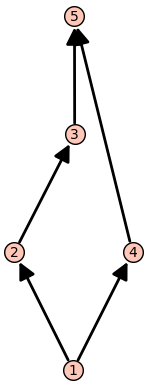

x0^4*x1^2 + x0^3*x1^3 + x0^2*x1^4 + x0^4*x1*x2 + 2*x0^3*x1^2*x2 + 2*x0^2*x1^3*x2 + x0*x1^4*x2 + x0^4*x2^2 + 2*x0^3*x1*x2^2 + 3*x0^2*x1^2*x2^2 + 2*x0*x1^3*x2^2 + x1^4*x2^2 + x0^3*x2^3 + 2*x0^2*x1*x2^3 + 2*x0*x1^2*x2^3 + x1^3*x2^3 + x0^2*x2^4 + x0*x1*x2^4 + x1^2*x2^4 + x0^3*x1^2*x3 + x0^3*x1*x2*x3 + x0^3*x2^2*x3 + x0^4*x3^2 + x0^3*x1*x3^2 + 2*x0^2*x1^2*x3^2 + x0^3*x2*x3^2 + 2*x0^2*x1*x2*x3^2 + 2*x0^2*x2^2*x3^2 + x0^3*x3^3 + x0^2*x3^4 + x0^4*x1*x4 + 2*x0^3*x1^2*x4 + 2*x0^2*x1^3*x4 + x0*x1^4*x4 + x0^4*x2*x4 + 3*x0^3*x1*x2*x4 + 4*x0^2*x1^2*x2*x4 + 3*x0*x1^3*x2*x4 + x1^4*x2*x4 + 2*x0^3*x2^2*x4 + 4*x0^2*x1*x2^2*x4 + 4*x0*x1^2*x2^2*x4 + 2*x1^3*x2^2*x4 + 2*x0^2*x2^3*x4 + 3*x0*x1*x2^3*x4 + 2*x1^2*x2^3*x4 + x0*x2^4*x4 + x1*x2^4*x4 + x0^4*x3*x4 + 2*x0^3*x1*x3*x4 + 2*x0^2*x1^2*x3*x4 + x0*x1^3*x3*x4 + 2*x0^3*x2*x3*x4 + 2*x0^2*x1*x2*x3*x4 + x0*x1^2*x2*x3*x4 + 2*x0^2*x2^2*x3*x4 + x0*x1*x2^2*x3*x4 + x0*x2^3*x3*x4 + 2*x0^3*x3^2*x4 + 2*x0^2*x1*x3^2*x4 + 2*x0^2*x2*x3^2*x4 + 2*x0^2*x3^3*x4 + x0*x1*x3^3*x4 

True
194


In [5]:
#elms = [1,2,3,4]
#rels = [[1,2],[1,3],[2,4],[3,4]]

elms = [1,2,3,4,5]
#rels = [[1,2],[1,3],[1,4],[2,5],[3,5],[4,5]]
rels = [[1,2],[2,3],[3,5],[1,4],[4,5]]

P = Poset((elms, rels), cover_relations = True)

H = P.hasse_diagram()
#H.plot(layout = 'acyclic')
H.show(layout = 'acyclic')

## --- ##

N = P.cardinality()
coeffs_ring = ZZ['q','t']
q = coeffs_ring.gens()[0]
t = coeffs_ring.gens()[1]

coeffs_field = coeffs_ring.fraction_field()
R=PolynomialRing(coeffs_field,N,'x')
xs=list(R.gens())

lam = [4,2]
mu = [2,1]

#print(PosetSchur(P,[7,3,1]))

f = PosetSchur(P,lam)
g = PosetSchur(P,mu)
print(f)
print("---")
print(g)
print("---")
print(f*g)
print("---")
print(is_P_symmetric(xs,P,f*g,[6,3]))
print(len(PosetTableaux(P,lam)))

In [5]:
elms = [1,2,3,4]
#rels = [[1,2],[1,3],[2,4],[3,4]]
rels = [[1,2],[2,3],[3,4]]

P = Poset((elms, rels), cover_relations = True)

N = P.cardinality()
    
coeffs_ring = ZZ['q','t']
q = coeffs_ring.gens()[0]
t = coeffs_ring.gens()[1]

coeffs_field = coeffs_ring.fraction_field()
R=PolynomialRing(coeffs_field,N,'x')
xs=list(R.gens())

arr = [[3,3],[2,2]]

print(is_P_tableau(P,arr))
print(tab_x_weight(arr,xs))

False
x1^2*x2^2


In [6]:
elms = [1,2,3,4]

rels = [[1,2],[1,3],[2,4],[3,4]]

# Chain relations
#rels = [[1,2],[2,3],[3,4]]

P = Poset((elms, rels), cover_relations = True)
N = P.cardinality()
    
coeffs_ring = ZZ['q','t']
q = coeffs_ring.gens()[0]
t = coeffs_ring.gens()[1]

coeffs_field = coeffs_ring.fraction_field()
R=PolynomialRing(coeffs_field,N,'x')
xs=list(R.gens())


lam = [2,1]
mu = [1,1]

#Ptab = PosetTableaux(P,lam)
#print(Ptab)
#print(len(Ptab))

PSchur_1 = PosetSchur(P,lam)

print((PSchur_1))
print(".")

print("---")

PSchur_2 = PosetSchur(P,mu)

print(PSchur_2)

print("----")

f = PSchur_1 * PSchur_2

print(f)

print(is_P_symmetric(xs,P,f,[5]))


x0^2*x1 + x0*x1^2 + x0^2*x2 + 2*x0*x1*x2 + x0*x2^2 + x0^2*x3 + 2*x0*x1*x3 + x1^2*x3 + 2*x0*x2*x3 + x2^2*x3 + x0*x3^2 + x1*x3^2 + x2*x3^2
.
---
x0*x1 + x0*x2 + x0*x3 + x1*x3 + x2*x3
----
x0^3*x1^2 + x0^2*x1^3 + 2*x0^3*x1*x2 + 3*x0^2*x1^2*x2 + x0^3*x2^2 + 3*x0^2*x1*x2^2 + x0^2*x2^3 + 2*x0^3*x1*x3 + 4*x0^2*x1^2*x3 + 2*x0*x1^3*x3 + 2*x0^3*x2*x3 + 8*x0^2*x1*x2*x3 + 4*x0*x1^2*x2*x3 + 4*x0^2*x2^2*x3 + 4*x0*x1*x2^2*x3 + 2*x0*x2^3*x3 + x0^3*x3^2 + 4*x0^2*x1*x3^2 + 4*x0*x1^2*x3^2 + x1^3*x3^2 + 4*x0^2*x2*x3^2 + 6*x0*x1*x2*x3^2 + x1^2*x2*x3^2 + 4*x0*x2^2*x3^2 + x1*x2^2*x3^2 + x2^3*x3^2 + x0^2*x3^3 + 2*x0*x1*x3^3 + x1^2*x3^3 + 2*x0*x2*x3^3 + 2*x1*x2*x3^3 + x2^2*x3^3
True


In [7]:
PosetSchur(P,[2,2,1])

x0^2*x1^2*x3 + x0^2*x2^2*x3 + x0^2*x1*x3^2 + x0*x1^2*x3^2 + x0^2*x2*x3^2 + 2*x0*x1*x2*x3^2 + x0*x2^2*x3^2

In [8]:
var(['a1','a2','a3','a4','a5','a6','a7','a8','a9','a10'])

f = PSchur_1 * PSchur_2 - a1*PosetSchur(P,[5])- a2*PosetSchur(P,[4,1]) - a3*PosetSchur(P,[3,2]) - a4*PosetSchur(P,[3,1,1]) - a5*PosetSchur(P,[2,2,1])- a6*PosetSchur(P,[2,1,1,1]) - a7*PosetSchur(P,[1,1,1,1,1])    
     
print(solve([f==0, a1 == 0, a2==0, a3==1, a4==1],a1,a2,a3,a4,a5,a6,a7))

[
[a1 == 0, a2 == 0, a3 == 1, a4 == 1, a5 == (2*x0^2*x1*x2^2 + 2*x1*x2*x3^3 + (x0^2*x1 + x0*x1^2 + (x0 + x1)*x2^2 + (x0^2 + 2*x0*x1 + x1^2)*x2)*x3^2 + 2*(x0^3*x1 + x0^2*x1^2)*x2 + (x0^2*x1^2 + (x0^2 + 2*x0*x1)*x2^2 + 2*(2*x0^2*x1 + x0*x1^2)*x2)*x3)/((x0^2*x1 + x0*x1^2 + x0*x2^2 + (x0^2 + 2*x0*x1)*x2)*x3^2 + (x0^2*x1^2 + x0^2*x2^2)*x3), a6 == r2, a7 == r1]
]


In [9]:
print(PosetSchur(P,[3,2]))

x0^3*x1^2 + x0^2*x1^3 + x0^2*x1^2*x2 + x0^3*x2^2 + x0^2*x1*x2^2 + x0^2*x2^3 + x0^3*x1*x3 + 2*x0^2*x1^2*x3 + x0*x1^3*x3 + x0^3*x2*x3 + 2*x0^2*x1*x2*x3 + x0*x1^2*x2*x3 + 2*x0^2*x2^2*x3 + x0*x1*x2^2*x3 + x0*x2^3*x3 + x0^3*x3^2 + 2*x0^2*x1*x3^2 + 2*x0*x1^2*x3^2 + x1^3*x3^2 + 2*x0^2*x2*x3^2 + 2*x0*x1*x2*x3^2 + 2*x0*x2^2*x3^2 + x2^3*x3^2 + x0^2*x3^3 + x0*x1*x3^3 + x1^2*x3^3 + x0*x2*x3^3 + x2^2*x3^3


## Poset Multiline queues

In [6]:
# Ball coordinates are pairs (i,j) where i is the label of the poset element and j is the height in the grid
# i is in {1,2,3,...,n}
# j is in {1,2,3,...,\ell(lambda)}


def balls_coordinates(P,balls):
    coords = []
    w = len(balls)
    l = len(balls[0])
    for i in range(w):
        for j in range(l):
            if balls[i][j] == 1: 
                coords.append([j+1,i+1])
    return(coords)

# word is a ternary word with 0,1,2 and 1=(, 2=) and 0=blank, to perform parenthesis matching algorithm
# returns the leftover letters from row1 after matching all possible 1s and 2s, and deleting unmatched 2s
def match_parenthesis(P,w):
    word = w.copy()
    boo = True
    while boo:
        p2 = -1
        p1 = -1
        for i in range(len(word)):
            #Find the first 2
            if word[i] == 2:
                p2 = i
            if p2 != -1:
                #Find the closest 1 that is comparable in the Poset
                crop = word[:p2+1]
                to_revise = [k for k in range(len(crop)) if crop[k] == 1]
                #print("lel")
                #print(to_revise)
                for j in reversed(range(len(crop))):
                    if crop[j] == 1:
                        p1 = j
                    if p1 != -1 and j in to_revise:
                        e1 = floor((p1)/2.0)+1
                        e2 = floor((p2)/2.0)+1
                        
                        #print(e1,e2)
                        
                        if (P.is_less_than(e1,e2) or e1==e2):
                            word[p2] = 0
                            word[p1] = 0   
                            break
                        else:
                            to_revise.remove(j)
                    if (j==0 and to_revise == []):
                        word[p2] = 0
                break
        if p2==-1:
            boo = False
    return(word)
    
# collapse row 1 on top of row 2
# this method updates row1 and row2
# wit is a boolean variable that says if a collapse occurred or not
def two_row_collapse(P,row1,row2):
    par_word = []
    wit = False
    # Create the parenthesis word to do the matching algorithm
    for i in range(len(row1)):
        if row1[i]==1:
            par_word.append(1)
        else:
            par_word.append(0)
        if row2[i]==1:
            par_word.append(2)
        else:
            par_word.append(0)
    # Apply parenthesis matching
    red_par_word = match_parenthesis(P,par_word)
    # Find indices on row1 to collapse
    coll = [red_par_word[i] for i in range(len(red_par_word)) if i%2==0] 
    pos = -1
    for i in range(len(row1)):
        if coll[i] == 1:
            pos = i
            wit = True
            row1[i] = 0
            row2[i] = 1
    #pos is the position of the collapse
    return(row1.copy(),row2.copy(),wit,pos)


class PosetMultilineQueue:
    queues = []
    n = 0
    
    def __init__(self,P,balls):
        self.balls = balls
        self.P = P
        self.size = [len(balls[0]),len(balls)]
        self.balls_coordinates = balls_coordinates(P,balls)
                
        self.n = self.P.cardinality()
        
    # This method creates the queues
    # 
    # case=0:   pairing to the right with (possibly) wrapping conditions
    #           pairing is done according to the linear order of the poset
    #           queues are given as sequences of coordinates starting from the top
    #
    # case=1:   minimal distance insertion-pairing to the right with no-wrapping
    #           collapses ball arrangement and pairs using case 0
    #
    # case=2:   
    #
    #    
        
    def pair(self,case):
        self.queues = []
        if case==0:       
            to_queue = []
            w = self.size[1]
            l = self.size[0]
            for i in range(w):
                for j in reversed(range(l)):
                    if self.balls[i][j] == 1: 
                        to_queue.append([j+1,i+1])
            
            #print(to_queue)
            cont = True
            while cont:
                b = to_queue[-1]
                #print(b)
                queue = [b]
                to_queue.remove(b)
                done = False
                b0 = b.copy()
                while not done:
                    j = b0[1]-1
                    l = [m for m in range(b0[0],self.P.cardinality()+1) 
                         if ((self.P.is_less_than(b0[0],m) or b0[0] == m) and ([m,j] in to_queue))]
                    #if b0 is at the bottom
                    if b0[1] == 1:
                        done = True
                    #otherwise
                    else:
                        #case 1: wrapping
                        if l==[]:
                            c = min([m for m in range(1,self.P.cardinality()+1) if ([m,j] in to_queue)])
                        #case 2: non-wrapping
                        else:
                            c = min(l)
                        
                        
                        
                        
                        queue.append([c,j])
                        to_queue.remove([c,j])
                        b0 = [c,j]
                self.queues.append(queue)
                if len(to_queue) == 0:
                    cont = False
                    
        if case == 1:
            self.collapse()
            while (self.size[0])*[0] in self.balls:
                self.balls.remove((self.size[0])*[0])
            self.size = [len(self.balls[0]),len(self.balls)]
            self.balls_coordinates = balls_coordinates(self.P,self.balls)
            self.pair(0)
            
                    
                    
    # 
    def insert_par(self,x):
        new_row = [0 for l in range(self.size[0])]
        new_row[x-1] = 1
        self.balls.append(new_row)
        self.size = [len(self.balls[0]),len(self.balls)]
        self.collapse()
        while (self.size[0])*[0] in self.balls:
                self.balls.remove((self.size[0])*[0])
        self.size = [len(self.balls[0]),len(self.balls)]
        self.balls_coordinates = balls_coordinates(self.P,self.balls)
        self.pair(0)
        
        
    def insert(self,x):
        new_row = [0 for l in range(self.size[0])]
        new_row[x-1] = 1
        self.balls.append(new_row)
        self.size = [len(self.balls[0]),len(self.balls)]
        self.collapse_and_update_queues(x)
        while (self.size[0])*[0] in self.balls:
                self.balls.remove((self.size[0])*[0])
        self.size = [len(self.balls[0]),len(self.balls)]
        self.balls_coordinates = balls_coordinates(self.P,self.balls)
        self.pair(1)
        
    
    def insert2(self,x):
        new_row = [0 for l in range(self.size[0])]
        new_row[x-1] = 1
        self.balls.append(new_row)
        self.size = [len(self.balls[0]),len(self.balls)]
        self.collapse_and_update_queues2(x)
        
        self.update_balls()
        
        
        while (self.size[0])*[0] in self.balls:
                self.balls.remove((self.size[0])*[0])
        self.size = [len(self.balls[0]),len(self.balls)]
        self.balls_coordinates = balls_coordinates(self.P,self.balls)
        
    
    
    # Collapsing procedure for the ball arrangement.
    # WARNING: This changes the original balls so that the new arrangement is non-wrapping
    #          
    
    def collapse(self):
        L = self.size[1]
        for i in range(1,L):
            for j in reversed(range(1,i+1)):
                row1 = self.balls[j-1].copy()
                row2 = self.balls[j].copy()
                [self.balls[j],self.balls[j-1],wit,num] = two_row_collapse(self.P,row2,row1)
        
        
    # Collapse of a single new ball, and keep old queues, while updating according to bumping
    def collapse_and_update_queues(self,x):
        L = self.size[1]
        for i in range(1,2):
            for j in reversed(range(1,L)):
                #Collapse the rows
                row1 = self.balls[j-1].copy()
                row2 = self.balls[j].copy()
                [self.balls[j],self.balls[j-1],wit,pos] = two_row_collapse(self.P,row2,row1)
                
                coll_ball = [pos+1,j+1]
                #print(pos)
                #print(coll_ball)
                
                #Update the queues
                if pos == -1:
                    self.pair(1)                             
                
                else:
                    if j==1:
                        self.queues.append([[pos+1,j]])
                        #print("Collapse")
                        #print(coll_ball)
                        #print(self.queues)

                        for q in self.queues:
                            #Check if the collapsed ball was in a queue
                            if (coll_ball in q):
                                #print("here")
                                ind = q.index(coll_ball)
                                q[ind] = [x,j+1]
                        
                        
                    else:
                        #print("Collapse")
                        #print(coll_ball)
                        #print(self.queues)

                        for q in self.queues:
                            #Check if the collapsed ball was in a queue
                            if (coll_ball in q):
                                #print("here")
                                ind = q.index(coll_ball)
                                q[ind] = [x,j+1]
                    
    
    ## :::::: ##
    
    def update_balls(self):
        M = max([q[0][1] for q in self.queues])
        empty_row = [0 for i in range(self.P.cardinality())]
        new_balls = [empty_row.copy() for j in range(M)]
        for q in self.queues:
            for b in q:
                el = b[0]
                h = b[1] 
                new_balls[h-1][el-1] = 1
        
        self.balls = new_balls
            
    
    
    def collapse_and_update_queues2(self,x):
        L = self.size[1]
        
        #List of balls to be inserted
        to_insert = [[x,L]]
        
        while (not to_insert == []):
            #print("to_insert")
            #print(to_insert)
            for b in to_insert:
                #print("Ball to be inserted")
                #print(b)
                if(b[1]==1):
                    to_insert.remove(b)
                    self.queues.append([b])
                    break
                
                #Possible balls to pair b
                possible_pairings = []
                for q in self.queues:
                    for part in q:
                        z = part[0]
                        h = part[1]
                        if(h==b[1]-1 and (self.P.is_less_than(b[0],z) or b[0] == z)):
                            possible_pairings.append([z,h])
                
                #print("Possible pairings")
                #print(possible_pairings)
            
                # Different cases of pairing possibilities:
                
                #Case 1: No balls to pair
                if possible_pairings == []:
                    #print(b)
                    to_insert.remove(b)
                    to_insert.append([b[0],b[1]-1])
                
                else:
                    #Put the possibilities to pair in increasing order
                    pairing_elems = [part[0] for part in possible_pairings]
                    pairing_elems.sort()
                    ordered_pairing_balls = []
                    for p in pairing_elems:
                        for ball in possible_pairings:
                            if(ball[0] == p):
                                ordered_pairing_balls.append([p,ball[1]])
                                break
                    #print("ordered")
                    #print(ordered_pairing_balls)
                    
                    #First, look for a pairing ball that is unmatched above
                    done = False
                    for p in ordered_pairing_balls:
                        #print("Looking for unmatched")
                        #print("Particle:")
                        #print(p)
                        upper_queue = []
                        for q in self.queues:
                            if p in q:
                                ind = q.index(p)
                                upper_queue = q[:ind]
                                break
                        #print("Upper queue")
                        #print(upper_queue)
                        if(upper_queue == []):
                            done = True
                            to_insert.remove(b)
                            for q in self.queues:
                                if p in q:
                                    q.insert(0,b)
                                    break
                        if(done):
                            break
                            
                    # If no pairing ball is unmatched above, pair with the closest one if possible      
                    if( not done ):
                        #print("Bumping")
                        pai = ordered_pairing_balls[0]
                        #print(pai)
                        upper_queue = []
                        for q in self.queues:
                            if pai in q:
                                ind = q.index(pai)
                                upper_queue = q[:ind]
                                befo = upper_queue[-1]
                                #Case 1: Bumping
                                if(befo[0] < b[0]):
                                    for el in reversed(upper_queue):
                                        q.remove(el)
                                        to_insert.append(el)

                                    to_insert.remove(b)
                                    q.insert(0,b)
                                    break
                                
                                else:
                                    to_insert.remove(b)
                                    to_insert.append([b[0],b[1]-1])
                                    break
                                
                                    
                    
            
    ##  ALGEBRAIC COMBINATORICS  ##
    
    #returns the x-weight of the multiline queue. Does not need to be paired
    def xweight(self):
        wei = xs[0]**0
        for b in self.balls_coordinates:
            wei *= xs[b[0]-1]
        return(wei)
        
    #Computes the major index of the MLQ
    def maj(self):
        wei = q**0
        for queue in self.queues:
            l = queue[0][1]
            for i in range(1,len(queue)):
                ci = queue[i-1][0]
                cf = queue[i][0]
                if not (self.P.is_less_than(ci,cf) or ci==cf):
                    wei *= q**(l+1-queue[i-1][1])
        return(wei)
    
    #Gives the partition type of the MLQ
    def partition(self):
        lam_prime = [sum(b) for b in self.balls]
        lam_p = Partition(lam_prime)
        return(lam_p.conjugate())


def are_equal(M1,M2):
    b = True
    Q1 = M1.queues
    Q2 = M2.queues
    
    for q1 in Q1:
        if q1 not in Q2:
            b = False
            break
            
    for q2 in Q2:
        if q2 not in Q1:
            b = False
            break
    
    return(b and M1.balls == M2.balls)

                        
def rho(P,word):
    n0 = word[0]
    word_c = word[1:]
    balls = []
    balls.append([0 for i in range((P.cardinality()))])
    balls[0][n0-1] = 1
    
    M = PosetMultilineQueue(P,balls)  
    M.pair(0)
    
    for w in word_c:
        M.insert(w)
        
    return(M)  

def rho2(P,word):
    n0 = word[0]
    word_c = word[1:]
    balls = []
    balls.append([0 for i in range((P.cardinality()))])
    balls[0][n0-1] = 1
    
    M = PosetMultilineQueue(P,balls)  
    M.pair(0)
    
    for w in word_c:
        M.insert2(w)
        
    return(M)  

def rho_par(P,word):
    n0 = word[0]
    word_c = word[1:]
    balls = []
    balls.append([0 for i in range((P.cardinality()))])
    balls[0][n0-1] = 1
    
    M = PosetMultilineQueue(P,balls)  
    M.pair(0)
    
    for w in word_c:
        M.insert_par(w)
        
    return(M)  

In [7]:
elms = [1,2,3,4]
rels = [[1,2],[1,3],[2,4],[3,4]]
#rels = [[1,2],[2,3],[3,4]]
P = Poset((elms, rels), cover_relations = True)

#balls = [[0,0,1,0],[1,0,0,0]]
#balls = [[1,0,1,0],[1,1,0,0],[1,0,0,1]]
#balls = [[0,0,1,1],[1,1,0,1]]

#balls = [[0,0,1,0],[1,0,0,0],[1,1,0,0]]
#balls = [[0,1,0,0],[1,0,0,0],[1,0,1,0]]

balls = [[0,1,0,0]]

M = PosetMultilineQueue(P,balls)
M.pair(0)

print("Original PMLQ")
print(M.balls)
print(M.queues)
print("---")

word = [1,3,2]

for w in word:
    print("Insertion of "+str(w))
    M.insert_par(w)
    print(M.balls)
    print(M.queues)
    print("---")


Original PMLQ
[[0, 1, 0, 0]]
[[[2, 1]]]
---
Insertion of 1
[[0, 1, 0, 0], [1, 0, 0, 0]]
[[[1, 2], [2, 1]]]
---
Insertion of 3
[[0, 1, 1, 0], [1, 0, 0, 0]]
[[[1, 2], [2, 1]], [[3, 1]]]
---
Insertion of 2
[[0, 1, 1, 0], [1, 1, 0, 0]]
[[[1, 2], [2, 1]], [[2, 2], [3, 1]]]
---


In [4]:
elms = [1,2,3,4]
rels = [[1,2],[1,3],[2,4],[3,4]]
#rels = [[1,2],[2,3],[3,4]]
P = Poset((elms, rels), cover_relations = True)

#balls = [[0,0,1,0],[1,0,0,0]]
#balls = [[1,0,1,0],[1,1,0,0],[1,0,0,1]]
#balls = [[0,0,1,1],[1,1,0,1]]

#balls = [[0,0,1,0],[1,0,0,0],[1,1,0,0]]
#balls = [[0,1,0,0],[1,0,0,0],[1,0,1,0]]

balls = [[0, 1, 1, 0], [1, 1, 0, 0]]

M = PosetMultilineQueue(P,balls)

print(M.balls)

M.pair(0)

print(M.queues)


[[0, 1, 1, 0], [1, 1, 0, 0]]
[[3, 1], [2, 1], [2, 2], [1, 2]]
[1, 2]
[2, 2]
[[[1, 2], [2, 1]], [[2, 2], [3, 1]]]


In [21]:
elms = [1,2,3,4]
rels = [[1,2],[1,3],[2,4],[3,4]]
P = Poset((elms, rels), cover_relations = True)

word = [1,1,2,3]

M1 = rho2(P,[2,1,1,3])
print(M1.balls)
print(M1.queues)

M2 = rho2(P,[3,1,1,2])
print(M2.balls)
print(M2.queues)

print(are_equal(M1,M2))


[[0, 1, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
[[[1, 3], [1, 2], [2, 1]], [[3, 1]]]
[[0, 1, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
[[[1, 3], [1, 2], [3, 1]], [[2, 1]]]
False


In [8]:
def rho_image(P,ell):
    #List of all words in |P| symbols, of length ell
    all_words = list(itertools.product(*[range(1,P.cardinality()+1) for j in range(ell)]))
    
    #List of all multiline queues that we get as an image of rho
    MLQ_image = []
    
    for w in all_words:
        M = rho_par(P,w)
        already_in = False
        for N in MLQ_image:
            if are_equal(M,N):
                already_in = True
                break
        
        if not already_in:
            MLQ_image.append(M)
            #print(w)
            #print(M.balls)
            #print(M.queues)
            #print(M.xweight())
            #print("-----")

    return(MLQ_image)
    
def PSchurMLQ(P,shape):
    n = P.cardinality()
    R=PolynomialRing(coeffs_field,n,'x')
    xs = R.gens()

    part = Partition(shape)
    ell = sum(part)
    
    PMLQ_complete_list = rho_image(P,ell)

    poly = 0
    
    for M in PMLQ_complete_list:
        if M.partition() == part:
            #print(M.balls)
            #print(M.queues)
            #print(M.xweight())
            #print("----")
            poly += M.xweight()
            
    return(poly)



In [9]:
elms = [1,2,3,4]
rels = [[1,2],[1,3],[2,4],[3,4]]
P = Poset((elms, rels), cover_relations = True)

M = rho2(P,[2,1,3,2,1,1])
print(M.balls)
print(M.queues)

M = rho2(P,[2,1,2,3,1,1])
print(M.balls)
print(M.queues)

[[0, 1, 1, 0], [1, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
[[[2, 2], [2, 1]], [[1, 4], [1, 3], [1, 2], [3, 1]]]
[[1, 1, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
[[[1, 4], [1, 3], [2, 2], [2, 1]], [[1, 1]], [[3, 1]]]


In [10]:
elms = [1,2,3,4]
rels = [[1,2],[1,3],[2,4],[3,4]]
P = Poset((elms, rels), cover_relations = True)

lam = [2,1,1]

pol = PSchurMLQ(P,lam)

print(pol)

print(is_P_symmetric(xs,P,pol,lam))



x0^2*x1*x2 + x0*x1^2*x2 + x0*x1*x2^2 + x0^2*x1*x3 + x0*x1^2*x3 + x0^2*x2*x3 + 3*x0*x1*x2*x3 + x1^2*x2*x3 + x0*x2^2*x3 + x1*x2^2*x3 + x0*x1*x3^2 + x0*x2*x3^2 + x1*x2*x3^2
True


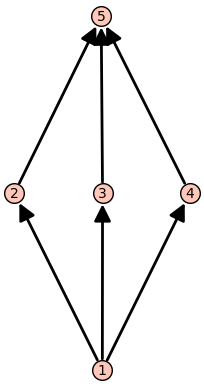

x0*x1 + x0*x2 + x1*x2 + x0*x3 + x1*x3 + x2*x3 + x0*x4 + x1*x4 + x2*x4 + x3*x4
True
---
x0^2 + x0*x1 + x1^2 + x0*x2 + x2^2 + x0*x3 + x3^2 + x0*x4 + x1*x4 + x2*x4 + x3*x4 + x4^2
True
---
x0^3*x1 + x0^2*x1^2 + x0*x1^3 + x0^3*x2 + 3*x0^2*x1*x2 + 2*x0*x1^2*x2 + x1^3*x2 + x0^2*x2^2 + 2*x0*x1*x2^2 + x0*x2^3 + x1*x2^3 + x0^3*x3 + 3*x0^2*x1*x3 + 2*x0*x1^2*x3 + x1^3*x3 + 3*x0^2*x2*x3 + 3*x0*x1*x2*x3 + x1^2*x2*x3 + 2*x0*x2^2*x3 + x1*x2^2*x3 + x2^3*x3 + x0^2*x3^2 + 2*x0*x1*x3^2 + 2*x0*x2*x3^2 + x1*x2*x3^2 + x0*x3^3 + x1*x3^3 + x2*x3^3 + x0^3*x4 + 3*x0^2*x1*x4 + 3*x0*x1^2*x4 + x1^3*x4 + 3*x0^2*x2*x4 + 5*x0*x1*x2*x4 + 2*x1^2*x2*x4 + 3*x0*x2^2*x4 + 2*x1*x2^2*x4 + x2^3*x4 + 3*x0^2*x3*x4 + 5*x0*x1*x3*x4 + 2*x1^2*x3*x4 + 5*x0*x2*x3*x4 + 3*x1*x2*x3*x4 + 2*x2^2*x3*x4 + 3*x0*x3^2*x4 + 2*x1*x3^2*x4 + 2*x2*x3^2*x4 + x3^3*x4 + x0^2*x4^2 + 3*x0*x1*x4^2 + x1^2*x4^2 + 3*x0*x2*x4^2 + 3*x1*x2*x4^2 + x2^2*x4^2 + 3*x0*x3*x4^2 + 3*x1*x3*x4^2 + 3*x2*x3*x4^2 + x3^2*x4^2 + x0*x4^3 + x1*x4^3 + x2*x4^3 + x3*x4^3
[4]
True


In [16]:
#elms = [1,2,3,4]
#rels = [[1,2],[1,3],[2,4],[3,4]]
#rels = [[1,2],[2,3],[3,4]]

elms = [1,2,3,4,5]
rels = [[1,2],[1,3],[1,4],[2,5],[3,5],[4,5]]
#rels = [[1,2],[2,3],[3,5],[1,4],[4,5]]
P = Poset((elms, rels), cover_relations = True)

P.show(layout = "acyclic")

n = P.cardinality()
coeffs_ring = ZZ['q','t']
q = coeffs_ring.gens()[0]
t = coeffs_ring.gens()[1]
coeffs_field = coeffs_ring.fraction_field()
R=PolynomialRing(coeffs_field,n,'x')
xs=list(R.gens())

lam = [1,1]
mu = [2]

s1 = PSchurMLQ(P,lam)
s2 = PSchurMLQ(P,mu)

print(s1)
print(is_P_symmetric(xs,P,s1,lam))
print("---")
print(s2)
print(is_P_symmetric(xs,P,s2,mu))
print("---")
s = s1*s2
print(s)
for part in Partitions(4):
    print(part)
    print(is_P_symmetric(xs,P,s2,part))

In [15]:
s([2]).expand(4)

TypeError: x must be of correct length

In [32]:
elms = [1,2,3,4]
rels = [[1,2],[1,3],[2,4],[3,4]]
#rels = [[1,2],[2,3],[3,4]]

P = Poset((elms, rels), cover_relations = True)

lam = [1,1]
mu = [2]

s1 = PSchurMLQ(P,lam)
s2 = PSchurMLQ(P,mu)

var(['a1','a2','a3','a4','a5','a6','a7','a8','a9','a10'])

f = s1*s2 - a1*PSchurMLQ(P,[4]) - a2*PSchurMLQ(P,[3,1]) - a3*PSchurMLQ(P,[2,2]) - a4*PSchurMLQ(P,[2,1,1]) - a5*PSchurMLQ(P,[1,1,1,1])

#f = s1 * s2 - a1*PSchurMLQ(P,[5]) - a2*PSchurMLQ(P,[4,1]) - a3*PSchurMLQ(P,[3,2]) - a4*PSchurMLQ(P,[3,1,1]) - a5*PSchurMLQ(P,[2,2,1])- a6*PSchurMLQ(P,[2,1,1,1])
     
print(solve([f==0,a1==0,a2==1,a3==0,a4==1],a1,a2,a3,a4,a5))

[
[a1 == 0, a2 == 1, a3 == 0, a4 == 1, a5 == x0/x3]
]


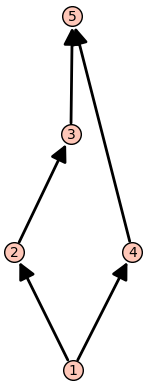

[
[a1 == 0, a2 == 1, a3 == 0, a4 == 1, a5 == (x0^2*x1 + (x0^2 + x0*x1)*x2)*x3/(x0*x1*x2*x3 + (x0*x1*x2 + (x0*x1 + (x0 + x1)*x2)*x3)*x4)]
]


In [35]:
elms = [1,2,3,4,5]
#rels = [[1,2],[1,3],[1,4],[2,5],[3,5],[4,5]]
rels = [[1,2],[2,3],[3,5],[1,4],[4,5]]

P = Poset((elms, rels), cover_relations = True)
P.show(layout = "acyclic")

n = P.cardinality()
coeffs_ring = ZZ['q','t']
q = coeffs_ring.gens()[0]
t = coeffs_ring.gens()[1]
coeffs_field = coeffs_ring.fraction_field()
R=PolynomialRing(coeffs_field,n,'x')
xs=list(R.gens())

lam = [1,1]
mu = [2]

s1 = PSchurMLQ(P,lam)
s2 = PSchurMLQ(P,mu)

var(['a1','a2','a3','a4','a5','a6','a7','a8','a9','a10'])

f = s1*s2 - a1*PSchurMLQ(P,[4]) - a2*PSchurMLQ(P,[3,1]) - a3*PSchurMLQ(P,[2,2]) - a4*PSchurMLQ(P,[2,1,1]) - a5*PSchurMLQ(P,[1,1,1,1])

#f = s1 * s2 - a1*PSchurMLQ(P,[5]) - a2*PSchurMLQ(P,[4,1]) - a3*PSchurMLQ(P,[3,2]) - a4*PSchurMLQ(P,[3,1,1]) - a5*PSchurMLQ(P,[2,2,1])- a6*PSchurMLQ(P,[2,1,1,1])
     
print(solve([f==0,a1==0,a2==1,a3==0,a4==1,],a1,a2,a3,a4,a5))

In [131]:
print(PSchurMLQ(P,[2,1,1,1]))

x0^2*x1*x2*x3 + x0*x1^2*x2*x3 + x0*x1*x2^2*x3 + x0*x1*x2*x3^2


In [495]:
print((s1*s2).coefficient(xs[0]*xs[0]*xs[2]*xs[3]))

3


In [504]:
print((PSchurMLQ(P,[3,1]))
      .coefficient(xs[0]*xs[0]*xs[2]*xs[3])
     )

(1, 1, 1, 1)
[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
[[[1, 4], [1, 3], [1, 2], [1, 1]]]
x0^4
-----
(1, 1, 1, 2)
[[1, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
[[[1, 3], [1, 2], [1, 1]], [[2, 1]]]
x0^3*x1
-----
(1, 1, 1, 3)
[[1, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
[[[1, 3], [1, 2], [1, 1]], [[3, 1]]]
x0^3*x2
-----
(1, 1, 1, 4)
[[1, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]
[[[1, 3], [1, 2], [1, 1]], [[4, 1]]]
x0^3*x3
-----
(1, 1, 2, 2)
[[1, 1, 0, 0], [1, 1, 0, 0]]
[[[1, 2], [1, 1]], [[2, 2], [2, 1]]]
x0^2*x1^2
-----
(1, 1, 2, 3)
[[1, 1, 1, 0], [1, 0, 0, 0]]
[[[1, 2], [1, 1]], [[2, 1]], [[3, 1]]]
x0^2*x1*x2
-----
(1, 1, 2, 4)
[[1, 1, 0, 1], [1, 0, 0, 0]]
[[[1, 2], [1, 1]], [[2, 1]], [[4, 1]]]
x0^2*x1*x3
-----
(1, 1, 3, 3)
[[1, 0, 1, 0], [1, 0, 1, 0]]
[[[1, 2], [1, 1]], [[3, 2], [3, 1]]]
x0^2*x2^2
-----
(1, 1, 3, 4)
[[1, 0, 1, 1], [1, 0, 0, 0]]
[[[1, 2], [1, 1]], [[3, 1]], [[4, 1]]]
x0^2*x2*x3
-----
(1, 1, 4, 2)
[[1, 0, 0, 1], [1, 1, 0, 0]]
[[[1, 2], [1, 1]], [[2, 2], [4, 1]]]


(4, 4, 2, 2)
[[0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0]]
[[[2, 4], [2, 3], [4, 2], [4, 1]]]
x1^2*x3^2
-----
(4, 4, 3, 1)
[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0]]
[[[1, 4], [3, 3], [4, 2], [4, 1]]]
x0*x2*x3^2
-----
(4, 4, 3, 3)
[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0]]
[[[3, 4], [3, 3], [4, 2], [4, 1]]]
x2^2*x3^2
-----
(4, 4, 4, 1)
[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0]]
[[[1, 4], [4, 3], [4, 2], [4, 1]]]
x0*x3^3
-----
(4, 4, 4, 2)
[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0]]
[[[2, 4], [4, 3], [4, 2], [4, 1]]]
x1*x3^3
-----
(4, 4, 4, 3)
[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0]]
[[[3, 4], [4, 3], [4, 2], [4, 1]]]
x2*x3^3
-----
(4, 4, 4, 4)
[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1]]
[[[4, 4], [4, 3], [4, 2], [4, 1]]]
x3^4
-----
[[1, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
[[[1, 3], [1, 2], [1, 1]], [[2, 1]]]
x0^3*x1
----
[[1, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
[[[1, 3], [1, 2], [1, 1]], 

In [493]:
print(PSchurMLQ(P,[2,1,1])== Poset_schur_mlq(P,[3,1]))

False


# Algebraic Combinatorics

In [39]:
##   Schur functions   ##

def Poset_schur_mlq(P,shape):
    n = P.cardinality()
    R=PolynomialRing(coeffs_field,n,'x')
    xs = R.gens()

    part = Partition(shape)
    mlq_shape = list(part.conjugate())
    
    aux_list = []
    ball_arrangements = []

    for i in mlq_shape:
        aux_list.append([list(sub) for sub in Subsets(range(n)) if len(sub) == i])

    ball_arr_coords = itertools.product(*aux_list)
    

    for tup in ball_arr_coords:
        ball_arr = []
        for row in tup:
            ball_row = [0 for j in range(n)]
            for i in range(n):
                if i in row:
                    ball_row[i] = 1
            ball_arr.append(ball_row.copy())
        ball_arrangements.append(ball_arr)
            
    

    # Create all Poset MLQs of given shape & compute the polynomial
    poly = 0

    for balls in ball_arrangements:
        M = PosetMultilineQueue(P,balls.copy())
        M.pair(0)
        if M.maj() == 1:
            #r=0.2
            #M.draw(r)
            poly += M.xweight()

    # Convert polynomial to symmetric function
    #f = sym.from_polynomial(poly)
    return(poly)


def monomial(xs,tup,comp):
    ans = xs[0]**0
    for i in range(len(tup)):
        ans *= xs[tup[i]-1]**comp[i]
    return(ans)        
        
    

In [40]:
print(Poset_schur_mlq(P,[2,2,2,1,1]))

0


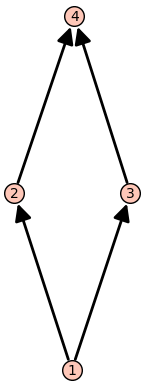

x0^5*x1^4*x2 + x0^4*x1^5*x2 + x0^3*x1^5*x2^2 + x0^2*x1^5*x2^3 + x0^5*x1*x2^4 + x0^4*x1^2*x2^4 + x0^3*x1^3*x2^4 + x0^2*x1^4*x2^4 + x0*x1^5*x2^4 + x0^4*x1*x2^5 + x0^3*x1^2*x2^5 + x0^2*x1^3*x2^5 + x0*x1^4*x2^5 + x0^5*x1^4*x3 + x0^4*x1^5*x3 + x0^5*x1^3*x2*x3 + 2*x0^4*x1^4*x2*x3 + 2*x0^3*x1^5*x2*x3 + x0^3*x1^4*x2^2*x3 + 2*x0^2*x1^5*x2^2*x3 + x0^5*x1*x2^3*x3 + x0^4*x1^2*x2^3*x3 + x0^3*x1^3*x2^3*x3 + 2*x0^2*x1^4*x2^3*x3 + 2*x0*x1^5*x2^3*x3 + x0^5*x2^4*x3 + 3*x0^4*x1*x2^4*x3 + 3*x0^3*x1^2*x2^4*x3 + 3*x0^2*x1^3*x2^4*x3 + 3*x0*x1^4*x2^4*x3 + x1^5*x2^4*x3 + x0^4*x2^5*x3 + 2*x0^3*x1*x2^5*x3 + 2*x0^2*x1^2*x2^5*x3 + 2*x0*x1^3*x2^5*x3 + x1^4*x2^5*x3 + x0^5*x1^3*x3^2 + 2*x0^4*x1^4*x3^2 + x0^3*x1^5*x3^2 + x0^5*x1^2*x2*x3^2 + 2*x0^4*x1^3*x2*x3^2 + 2*x0^3*x1^4*x2*x3^2 + 2*x0^2*x1^5*x2*x3^2 + x0^5*x1*x2^2*x3^2 + 2*x0^4*x1^2*x2^2*x3^2 + 3*x0^3*x1^3*x2^2*x3^2 + 2*x0^2*x1^4*x2^2*x3^2 + 2*x0*x1^5*x2^2*x3^2 + x0^5*x2^3*x3^2 + 2*x0^4*x1*x2^3*x3^2 + 2*x0^3*x1^2*x2^3*x3^2 + 3*x0^2*x1^3*x2^3*x3^2 + 3*x0*x1^4*x2^3*

In [12]:
elms = [1,2,3,4]
rels = [[1,2],[1,3],[2,4],[3,4]]
#rels = [[1,2],[2,3],[3,4]]

#elms = [1,2,3,4,5]
#rels = [[1,2],[1,3],[1,4],[2,5],[3,5],[4,5]]
#rels = [[1,2],[2,3],[3,5],[1,4],[4,5]]
P = Poset((elms, rels), cover_relations = True)

P.show(layout = "acyclic")

n = P.cardinality()
coeffs_ring = ZZ['q','t']
q = coeffs_ring.gens()[0]
t = coeffs_ring.gens()[1]
coeffs_field = coeffs_ring.fraction_field()
R=PolynomialRing(coeffs_field,n,'x')
xs=list(R.gens())

lam = [5,4,1]

s1 = Poset_schur_mlq(P,lam)

f1 = PosetSchur(P,lam)

print(s1)
print(is_P_symmetric(xs,P,s1,lam))



print(f1)

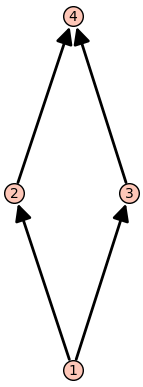

x0^2 + x0*x1 + x1^2 + x0*x2 + x2^2 + x0*x3 + x1*x3 + x2*x3 + x3^2
---
x0*x1 + x0*x2 + x1*x2 + x0*x3 + x1*x3 + x2*x3
---


x0^3*x1 + x0^2*x1^2 + x0*x1^3 + x0^3*x2 + 3*x0^2*x1*x2 + 2*x0*x1^2*x2 + x1^3*x2 + x0^2*x2^2 + 2*x0*x1*x2^2 + x0*x2^3 + x1*x2^3 + x0^3*x3 + 3*x0^2*x1*x3 + 3*x0*x1^2*x3 + x1^3*x3 + 3*x0^2*x2*x3 + 5*x0*x1*x2*x3 + 2*x1^2*x2*x3 + 3*x0*x2^2*x3 + 2*x1*x2^2*x3 + x2^3*x3 + x0^2*x3^2 + 3*x0*x1*x3^2 + x1^2*x3^2 + 3*x0*x2*x3^2 + 3*x1*x2*x3^2 + x2^2*x3^2 + x0*x3^3 + x1*x3^3 + x2*x3^3

In [77]:
elms = [1,2,3,4]
rels = [[1,2],[1,3],[2,4],[3,4]]
#rels = [[1,2],[2,3],[3,4]]

#elms = [1,2,3,4,5]
#rels = [[1,2],[1,3],[1,4],[2,5],[3,5],[4,5]]
#rels = [[1,2],[2,3],[3,5],[1,4],[4,5]]
P = Poset((elms, rels), cover_relations = True)

P.show(layout = "acyclic")

n = P.cardinality()
coeffs_ring = ZZ['q','t']
q = coeffs_ring.gens()[0]
t = coeffs_ring.gens()[1]
coeffs_field = coeffs_ring.fraction_field()
R=PolynomialRing(coeffs_field,n,'x')
xs=list(R.gens())

lam = [2]
mu = [1,1]

s1 = Poset_schur_mlq(P,lam)
s2 = Poset_schur_mlq(P,mu)

print(s1)
print("---")
print(s2)
print("---")
g = s1*s2
display(g)

In [81]:
Poset_schur_mlq(P,[1,1,1,1])

x0*x1*x2*x3

In [80]:
f = g - Poset_schur_mlq(P,[3,1]) - Poset_schur_mlq(P,[2,1,1]) 

display(f)

x0^2*x1*x2

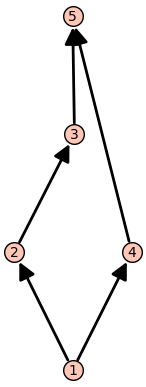

True
0
0
x0^4*x1^2*x2^2 + x0^3*x1^3*x2^2 + x0^2*x1^4*x2^2 + x0^3*x1^2*x2^3 + x0^2*x1^3*x2^3 + x0^2*x1^2*x2^4 + x0^4*x1^2*x3^2 + x0^3*x1^3*x3^2 + x0^2*x1^4*x3^2 + x0^4*x1*x2*x3^2 + 2*x0^3*x1^2*x2*x3^2 + 2*x0^2*x1^3*x2*x3^2 + x0*x1^4*x2*x3^2 + x0^4*x2^2*x3^2 + 2*x0^3*x1*x2^2*x3^2 + 3*x0^2*x1^2*x2^2*x3^2 + 2*x0*x1^3*x2^2*x3^2 + x1^4*x2^2*x3^2 + x0^3*x2^3*x3^2 + 2*x0^2*x1*x2^3*x3^2 + 2*x0*x1^2*x2^3*x3^2 + x1^3*x2^3*x3^2 + x0^2*x2^4*x3^2 + x0*x1*x2^4*x3^2 + x1^2*x2^4*x3^2 + x0^3*x1^2*x3^3 + x0^3*x1*x2*x3^3 + x0^2*x1^2*x2*x3^3 + x0^3*x2^2*x3^3 + x0^2*x1*x2^2*x3^3 + x0*x1^2*x2^2*x3^3 + x0^2*x1^2*x3^4 + x0^2*x1*x2*x3^4 + x0*x1^2*x2*x3^4 + x0^2*x2^2*x3^4 + x0*x1*x2^2*x3^4 + x1^2*x2^2*x3^4 + x0^4*x1^2*x2*x4 + x0^3*x1^3*x2*x4 + x0^2*x1^4*x2*x4 + x0^4*x1*x2^2*x4 + 3*x0^3*x1^2*x2^2*x4 + 3*x0^2*x1^3*x2^2*x4 + x0*x1^4*x2^2*x4 + x0^3*x1*x2^3*x4 + 3*x0^2*x1^2*x2^3*x4 + x0*x1^3*x2^3*x4 + x0^2*x1*x2^4*x4 + x0*x1^2*x2^4*x4 + x0^4*x1^2*x3*x4 + x0^3*x1^3*x3*x4 + x0^2*x1^4*x3*x4 + x0^4*x1*x2*x3*x4 + 2*x0^3*x

In [218]:
#elms = [1,2,3,4]
#rels = [[1,2],[1,3],[2,4],[3,4]]
#rels = [[1,2],[2,3],[3,4]]

elms = [1,2,3,4,5]
#rels = [[1,2],[1,3],[1,4],[2,5],[3,5],[4,5]]
rels = [[1,2],[2,3],[3,5],[1,4],[4,5]]
P = Poset((elms, rels), cover_relations = True)

P.show(layout = "acyclic")

n = P.cardinality()
coeffs_ring = ZZ['q','t']
q = coeffs_ring.gens()[0]
t = coeffs_ring.gens()[1]
coeffs_field = coeffs_ring.fraction_field()
R=PolynomialRing(coeffs_field,n,'x')
xs=list(R.gens())

lam = [4,2,2]
#mu = [1,1]

s1 = Poset_schur_mlq(P,lam)


expo = [4,4]

l1 = [1,4]
l2 = [2,3]

Q = P.subposet(l1)
#Q.show(layout = "acyclic")
R = P.subposet(l2)
#R.show(layout = "acyclic")

print(Q.is_isomorphic(R))

print(s1.coefficient(monomial(xs,l1,expo)))
print(s1.coefficient(monomial(xs,l2,expo)))


print(s1)

#s2 = Poset_schur_mlq(P,mu)

#print(s1)
#print("---")
#print(s2)
#print("---")
#print(s1*s2)

In [269]:
Partitions(4).list()

[[4], [3, 1], [2, 2], [2, 1, 1], [1, 1, 1, 1]]

In [76]:
elms = [1,2,3,4]
rels = [[1,2],[1,3],[2,4],[3,4]]
#rels = [[1,2],[2,3],[3,4]]
P = Poset((elms, rels), cover_relations = True)

lam = [1,1]
mu = [2]

s1 = Poset_schur_mlq(P,lam)
s2 = Poset_schur_mlq(P,mu)

var(['a1','a2','a3','a4','a5','a6','a7','a8','a9','a10'])

f = s1*s2 - a1*Poset_schur_mlq(P,[4]) - a2*Poset_schur_mlq(P,[3,1]) - a3*Poset_schur_mlq(P,[2,2]) - a4*Poset_schur_mlq(P,[2,1,1]) - a5*Poset_schur_mlq(P,[1,1,1,1])

#f = s1 * s2 - a1*Poset_schur_mlq(P,[5]) - a2*Poset_schur_mlq(P,[4,1]) - a3*Poset_schur_mlq(P,[3,2]) - a4*Poset_schur_mlq(P,[3,1,1]) - a5*Poset_schur_mlq(P,[2,2,1])- a6*Poset_schur_mlq(P,[2,1,1,1])
     
print(solve([f==0,a1==0,a2==1,a3==0,a4==1],a1,a2,a3,a4,a5))

[
[a1 == 0, a2 == 1, a3 == 0, a4 == 1, a5 == x0/x3]
]


In [109]:
print(s1 * s2 
      - 0*Poset_schur_mlq(P,[5]) 
      - 0*Poset_schur_mlq(P,[4,1]) 
      - 1*Poset_schur_mlq(P,[3,2]) 
      - 1*Poset_schur_mlq(P,[3,1,1]) 
      - 1*Poset_schur_mlq(P,[2,2,1])
      - 1*Poset_schur_mlq(P,[2,1,1,1])
)

x0^3*x1*x2 + x0^2*x1^2*x2 + x0*x1^2*x2^2 + x0*x1^2*x2*x3 + x0*x1*x2^2*x3 + x1^2*x2^2*x3 + 2*x0*x1*x2*x3^2 + x1^2*x2*x3^2 + x1*x2^2*x3^2 + x1*x2*x3^3


In [103]:
print(Poset_schur_mlq(P,[2,1,1,1]))

x0^2*x1*x2*x3 + x0*x1^2*x2*x3 + x0*x1*x2^2*x3 + x0*x1*x2*x3^2


In [90]:
print(Poset_schur_mlq(P,[2,1,1])
      #.coefficient(xs[0]**2*xs[1]*xs[2])
     )

x0^2*x1*x2 + x0*x1^2*x2 + x0*x1*x2^2 + x0^2*x1*x3 + x0*x1^2*x3 + x0^2*x2*x3 + 3*x0*x1*x2*x3 + x1^2*x2*x3 + x0*x2^2*x3 + x1*x2^2*x3 + x0*x1*x3^2 + x0*x2*x3^2 + x1*x2*x3^2


In [76]:
lam = [1,1]

print(PosetSchur(P,lam) - Poset_schur_mlq(P,lam)
      #.coefficient(xs[0]**2*xs[1]*xs[2])
     )

x1*x2


In [50]:
print(Poset_schur_mlq(P,[2,1,1]).coefficient(xs[0]**2*xs[1]*xs[2]))

1


In [53]:
print((s1*s2).coefficient(xs[0]**2*xs[1]*xs[2]))

3


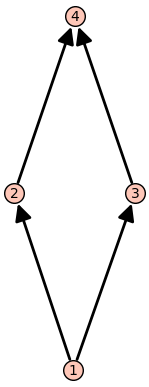

13
[([1, 1], [2, 2]), ([1, 1], [2, 4]), ([1, 1], [3, 3]), ([1, 1], [3, 4]), ([1, 1], [4, 4]), ([1, 2], [2, 4]), ([1, 2], [3, 4]), ([1, 2], [4, 4]), ([1, 3], [2, 4]), ([1, 3], [3, 4]), ([1, 3], [4, 4]), ([2, 2], [4, 4]), ([3, 3], [4, 4])]
18


In [98]:
#elms = [1,2,3,4,5]
#rels = [[1,2],[1,3],[1,4],[2,5],[3,5],[4,5]]
#rels = [[1,2],[2,3],[3,5],[1,4],[4,5]]

elms = [1,2,3,4]
rels = [[1,2],[1,3],[2,4],[3,4]]
#rels = [[1,2],[2,3],[3,4]]


P = Poset((elms, rels), cover_relations = True)

H = P.hasse_diagram()
#H.plot(layout = 'acyclic')
H.show(layout = 'acyclic')

## --- ##

N = P.cardinality()
coeffs_ring = ZZ['q','t']
q = coeffs_ring.gens()[0]
t = coeffs_ring.gens()[1]

coeffs_field = coeffs_ring.fraction_field()
R=PolynomialRing(coeffs_field,N,'x')
xs=list(R.gens())

lam = [2,2]

print(len(PosetTableaux(P,lam)))

print(PosetTableaux(P,lam))

print(len([M for M in rho_image(P,sum(lam)) if M.partition() == lam]))

In [ ]:
var('A B C D q t')

S = solve([A*(1+t) == B*t+C,
           B*(1+t) == C*t+A,
           C*(1+t) == A*t+C,
            ]
            ,A,B,C)

print(S)

# Particle Dynamics

In [1]:
%display latex

In [42]:
var('A B C D q t')

S = solve([A*(1+q) == B*q + C*q + D,
             B*(1+q) == A*t + D*q*(t),
             C*(1+q) == A*(1-t) + D*q*(1-t),
             D*(1+q) == A*q + B + C,
            ]
            ,A,B,C,D)

print(S)

[
[A == r13, B == r13*t, C == -r13*t + r13, D == r13]
]


In [68]:
var('A B C D q s1 s2 s3 s4')

S = solve([A*(s1+s2+q) == B*q + C*q + D,
             B*(1+q) == A*s1 + D*q*s3,
             C*(1+q) == A*s2 + D*q*s4,
             D*(1+q*(s3+s4)) == A*q + B + C,
             A + B + C + D == 1
            ]
            ,A,B,C,D)

print(S)

TypeError: ECL says: THROW: The catch MACSYMA-QUIT is undefined.

In [67]:
f1 = (q^2*(s3 + s4) + q + 1)/(q^2*(2*s3 + 2*s4 + 1) + (q*(s3 + s4) + 2)*s1 + (q*(s3 + s4) + 2)*s2 + 2*q + 1)
f2 =(q^3*s3 + q^2*s3 + q*s2*s3 + (q^2*(s3 + s4) + q*(s3 + 1) + 1)*s1)/(q^3*(2*s3 + 2*s4 + 1) + q^2*(2*s3 + 2*s4 + 3) + (q^2*(s3 + s4) + q*(s3 + s4 + 2) + 2)*s1 + (q^2*(s3 + s4) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1)
f3 = (q^3*s4 + q^2*s4 + q*s1*s4 + (q^2*(s3 + s4) + q*(s4 + 1) + 1)*s2)/(q^3*(2*s3 + 2*s4 + 1) + q^2*(2*s3 + 2*s4 + 3) + (q^2*(s3 + s4) + q*(s3 + s4 + 2) + 2)*s1 + (q^2*(s3 + s4) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1)
f4 = (q^2 + q + s1 + s2)/(q^2*(2*s3 + 2*s4 + 1) + (q*(s3 + s4) + 2)*s1 + (q*(s3 + s4) + 2)*s2 + 2*q + 1)

F = [f1,f2,f3,f4]

Z = f2.denominator()

display(Z.subs(q=1,s1=1,s2=1,s3=1,s4=1))

for f in F:
    display((f.subs(s1=s1).subs(s2=s2)))

32

(q^2*(s3 + s4) + q + 1)/(q^2*(2*s3 + 2*s4 + 1) + (q*(s3 + s4) + 2)*s1 + (q*(s3 + s4) + 2)*s2 + 2*q + 1)

(q^3*s3 + q^2*s3 + q*s2*s3 + (q^2*(s3 + s4) + q*(s3 + 1) + 1)*s1)/(q^3*(2*s3 + 2*s4 + 1) + q^2*(2*s3 + 2*s4 + 3) + (q^2*(s3 + s4) + q*(s3 + s4 + 2) + 2)*s1 + (q^2*(s3 + s4) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1)

(q^3*s4 + q^2*s4 + q*s1*s4 + (q^2*(s3 + s4) + q*(s4 + 1) + 1)*s2)/(q^3*(2*s3 + 2*s4 + 1) + q^2*(2*s3 + 2*s4 + 3) + (q^2*(s3 + s4) + q*(s3 + s4 + 2) + 2)*s1 + (q^2*(s3 + s4) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1)

(q^2 + q + s1 + s2)/(q^2*(2*s3 + 2*s4 + 1) + (q*(s3 + s4) + 2)*s1 + (q*(s3 + s4) + 2)*s2 + 2*q + 1)

In [64]:
Z = f2.denominator()

display(Z.subs(q=1,s1=1,s2=1,s3=1,s4=1))

display(Z)

32

2*q^3*s3 + q^2*s1*s3 + q^2*s2*s3 + 2*q^3*s4 + q^2*s1*s4 + q^2*s2*s4 + q^3 + 2*q^2*s3 + q*s1*s3 + q*s2*s3 + 2*q^2*s4 + q*s1*s4 + q*s2*s4 + 3*q^2 + 2*q*s1 + 2*q*s2 + 3*q + 2*s1 + 2*s2 + 1

In [60]:
#Nice case:
var("r14")

f1 = (q^2*r14*s1 + q^2*r14*s2 + q*r14 + r14)/(q^2 + q + s1 + s2)
f2 = (q*r14*s1^2 + q*r14*s1*s2 + (q^2*r14 + r14)*s1)/(q^2 + q + s1 + s2)
f3 = (q*r14*s2^2 + (q^2*r14 + q*r14*s1 + r14)*s2)/(q^2 + q + s1 + s2)
f4 = r14

display((f1+f2+f3+f4).factor())

F = [f1,f2,f3,f4]

for f in F:
    display((f.subs(s1=s1).subs(s2=s2)))

(2*q^2*s1 + q*s1^2 + 2*q^2*s2 + 2*q*s1*s2 + q*s2^2 + q^2 + 2*q + 2*s1 + 2*s2 + 1)*r14/(q^2 + q + s1 + s2)

(q^2*s1 + q^2*s2 + q + 1)*r14/(q^2 + q + s1 + s2)

(q^2 + q*s1 + q*s2 + 1)*r14*s1/(q^2 + q + s1 + s2)

(q^2 + q*s1 + q*s2 + 1)*r14*s2/(q^2 + q + s1 + s2)

r14

In [20]:
var('A B C D E q s1 s2 s3 s4 s5 s6')

S = solve([A*(s1+s2+s3+q) == B*q + C*q + D*q + E,
             B*(1+q) == A*s1 + E*q*s4,
             C*(1+q) == A*s2 + E*q*s5,
             D*(1+q) == A*s3 + E*q*s6,
             E*(1+q*(s4+s5+s6)) == A*q + B + C + D,
             A+B+C+D+E == 1
            ]
            ,A,B,C,D,E)

print(S)

[
[A == (q^2*(s4 + s5 + s6) + q + 1)/(q^2*(2*s4 + 2*s5 + 2*s6 + 1) + (q*(s4 + s5 + s6) + 2)*s1 + (q*(s4 + s5 + s6) + 2)*s2 + (q*(s4 + s5 + s6) + 2)*s3 + 2*q + 1), B == (q^3*s4 + q^2*s4 + q*s2*s4 + q*s3*s4 + (q^2*(s4 + s5 + s6) + q*(s4 + 1) + 1)*s1)/(q^3*(2*s4 + 2*s5 + 2*s6 + 1) + q^2*(2*s4 + 2*s5 + 2*s6 + 3) + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s1 + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s2 + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s3 + 3*q + 1), C == (q^3*s5 + q^2*s5 + q*s1*s5 + q*s3*s5 + (q^2*(s4 + s5 + s6) + q*(s5 + 1) + 1)*s2)/(q^3*(2*s4 + 2*s5 + 2*s6 + 1) + q^2*(2*s4 + 2*s5 + 2*s6 + 3) + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s1 + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s2 + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s3 + 3*q + 1), D == (q^3*s6 + q^2*s6 + q*s1*s6 + q*s2*s6 + (q^2*(s4 + s5 + s6) + q*(s6 + 1) + 1)*s3)/(q^3*(2*s4 + 2*s5 + 2*s6 + 1) + q^2*(2*s4 + 2*s5 + 2*s6 + 3) + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s1 +

In [22]:
f1 = (q^2*(s4 + s5 + s6) + q + 1)/(q^2*(2*s4 + 2*s5 + 2*s6 + 1) + (q*(s4 + s5 + s6) + 2)*s1 + (q*(s4 + s5 + s6) + 2)*s2 + (q*(s4 + s5 + s6) + 2)*s3 + 2*q + 1)
f2 = (q^3*s4 + q^2*s4 + q*s2*s4 + q*s3*s4 + (q^2*(s4 + s5 + s6) + q*(s4 + 1) + 1)*s1)/(q^3*(2*s4 + 2*s5 + 2*s6 + 1) + q^2*(2*s4 + 2*s5 + 2*s6 + 3) + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s1 + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s2 + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s3 + 3*q + 1)
f3 = (q^3*s5 + q^2*s5 + q*s1*s5 + q*s3*s5 + (q^2*(s4 + s5 + s6) + q*(s5 + 1) + 1)*s2)/(q^3*(2*s4 + 2*s5 + 2*s6 + 1) + q^2*(2*s4 + 2*s5 + 2*s6 + 3) + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s1 + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s2 + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s3 + 3*q + 1)
f4 = (q^3*s6 + q^2*s6 + q*s1*s6 + q*s2*s6 + (q^2*(s4 + s5 + s6) + q*(s6 + 1) + 1)*s3)/(q^3*(2*s4 + 2*s5 + 2*s6 + 1) + q^2*(2*s4 + 2*s5 + 2*s6 + 3) + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s1 + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s2 + (q^2*(s4 + s5 + s6) + q*(s4 + s5 + s6 + 2) + 2)*s3 + 3*q + 1)
f5 = (q^2 + q + s1 + s2 + s3)/(q^2*(2*s4 + 2*s5 + 2*s6 + 1) + (q*(s4 + s5 + s6) + 2)*s1 + (q*(s4 + s5 + s6) + 2)*s2 + (q*(s4 + s5 + s6) + 2)*s3 + 2*q + 1)

Z = f2.denominator()

display(Z.subs(q=1,s1=1,s2=1,s3=1,s4=1,s5=1,s6=1))

F = [f1,f2,f3,f4,f5]

for f in F:
    display((f.subs(s1=s1).subs(s2=s2)).factor())

50

(q^2*s4 + q^2*s5 + q^2*s6 + q + 1)/(2*q^2*s4 + q*s1*s4 + q*s2*s4 + q*s3*s4 + 2*q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + 2*q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q^2 + 2*q + 2*s1 + 2*s2 + 2*s3 + 1)

(q^3*s4 + q^2*s1*s4 + q^2*s1*s5 + q^2*s1*s6 + q^2*s4 + q*s1*s4 + q*s2*s4 + q*s3*s4 + q*s1 + s1)/((2*q^2*s4 + q*s1*s4 + q*s2*s4 + q*s3*s4 + 2*q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + 2*q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q^2 + 2*q + 2*s1 + 2*s2 + 2*s3 + 1)*(q + 1))

(q^2*s2*s4 + q^3*s5 + q^2*s2*s5 + q^2*s2*s6 + q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + q*s2 + s2)/((2*q^2*s4 + q*s1*s4 + q*s2*s4 + q*s3*s4 + 2*q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + 2*q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q^2 + 2*q + 2*s1 + 2*s2 + 2*s3 + 1)*(q + 1))

(q^2*s3*s4 + q^2*s3*s5 + q^3*s6 + q^2*s3*s6 + q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q*s3 + s3)/((2*q^2*s4 + q*s1*s4 + q*s2*s4 + q*s3*s4 + 2*q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + 2*q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q^2 + 2*q + 2*s1 + 2*s2 + 2*s3 + 1)*(q + 1))

(q^2 + q + s1 + s2 + s3)/(2*q^2*s4 + q*s1*s4 + q*s2*s4 + q*s3*s4 + 2*q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + 2*q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q^2 + 2*q + 2*s1 + 2*s2 + 2*s3 + 1)

In [24]:
var('A B C D E q s1 s2 s3 s4')

S = solve([A*(s1+s2+q) == B*q + D*q + E,
             B*(1+q) == C*q + A*s1,
             C*(1+q) == B + E*q*s3,
             D*(1+q) == A*s2 + E*q*s4,
             E*(1+q*(s3+s4)) == A*q + C + D,
             A+B+C+D+E == 1
            ]
            ,A,B,C,D,E)

print(S)

[
[A == (q^4*(s3 + s4) + q^3*(s3 + s4 + 1) + q^2*(s4 + 2) + 2*q + 1)/(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1), B == (q^4*s3 + q^3*s3 + q^2*s2*s3 + (q^3*(s3 + s4) + q^2*(s3 + s4 + 1) + 2*q + 1)*s1)/(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1), C == (q^4*s3 + 2*q^3*s3 + q^2*s3 + (q^2*(s3 + s4) + q*(s3 + 1) + 1)*s1 + (q^2*s3 + q*s3)*s2)/(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1), D == (q^4*s4 + q^3*s4 + q^2*s4 + q*s1*s4 + (q^3*(s3 + s4) + q^2*(s4 + 1) + q*(s4 + 1) + 1)*s2)/(q^4*(3*s3 + 2*s4 

In [71]:
eqs = [A*(s1+s2+q) == B*q + D*q + E,
             B*(1+q) == C*q + A*s1,
             C*(1+q) == B + E*q*s3,
             D*(1+q) == A*s2 + E*q*s4,
             E*(1+q*(s3+s4)) == A*q + C + D]

eqs.append(A+B+C+D+E == 1)

S = solve(eqs,A,B,C,D,E)

print(S)

[
[A == (q^4*(s3 + s4) + q^3*(s3 + s4 + 1) + q^2*(s4 + 2) + 2*q + 1)/(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1), B == (q^4*s3 + q^3*s3 + q^2*s2*s3 + (q^3*(s3 + s4) + q^2*(s3 + s4 + 1) + 2*q + 1)*s1)/(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1), C == (q^4*s3 + 2*q^3*s3 + q^2*s3 + (q^2*(s3 + s4) + q*(s3 + 1) + 1)*s1 + (q^2*s3 + q*s3)*s2)/(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1), D == (q^4*s4 + q^3*s4 + q^2*s4 + q*s1*s4 + (q^3*(s3 + s4) + q^2*(s4 + 1) + q*(s4 + 1) + 1)*s2)/(q^4*(3*s3 + 2*s4 

In [48]:
Z=(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1)

display(Z.subs(q=1,s1=1,s2=1,s3=1,s4=1))

55

In [18]:
f1 = (q^4*(s3 + s4) + q^3*(s3 + s4 + 1) + q^2*(s4 + 2) + 2*q + 1)/(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1)
f2 = (q^4*s3 + q^3*s3 + q^2*s2*s3 + (q^3*(s3 + s4) + q^2*(s3 + s4 + 1) + 2*q + 1)*s1)/(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1)
f3 = (q^4*s3 + 2*q^3*s3 + q^2*s3 + (q^2*(s3 + s4) + q*(s3 + 1) + 1)*s1 + (q^2*s3 + q*s3)*s2)/(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1)
f4 = (q^4*s4 + q^3*s4 + q^2*s4 + q*s1*s4 + (q^3*(s3 + s4) + q^2*(s4 + 1) + q*(s4 + 1) + 1)*s2)/(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1)
f5 = (q^4 + 2*q^3 + 2*q^2 + (q + 1)*s1 + (q^2 + q + 1)*s2 + q)/(q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1)
F = [f1,f2,f3,f4,f5]

Z = f1.denominator()
display(Z.subs(q=1,s1=1,s2=1,s3=1,s4=1))


for f in F:
    display(f.factor())

55

(q^4*s3 + q^4*s4 + q^3*s3 + q^3*s4 + q^3 + q^2*s4 + 2*q^2 + 2*q + 1)/(3*q^4*s3 + q^3*s1*s3 + q^3*s2*s3 + 2*q^4*s4 + q^3*s1*s4 + q^3*s2*s4 + q^4 + 4*q^3*s3 + 2*q^2*s1*s3 + 2*q^2*s2*s3 + 2*q^3*s4 + 2*q^2*s1*s4 + q^2*s2*s4 + 3*q^3 + q^2*s1 + 2*q^2*s2 + q^2*s3 + q*s1*s3 + q*s2*s3 + 2*q^2*s4 + q*s1*s4 + q*s2*s4 + 4*q^2 + 4*q*s1 + 2*q*s2 + 3*q + 3*s1 + 2*s2 + 1)

(q^4*s3 + q^3*s1*s3 + q^3*s1*s4 + q^3*s3 + q^2*s1*s3 + q^2*s2*s3 + q^2*s1*s4 + q^2*s1 + 2*q*s1 + s1)/(3*q^4*s3 + q^3*s1*s3 + q^3*s2*s3 + 2*q^4*s4 + q^3*s1*s4 + q^3*s2*s4 + q^4 + 4*q^3*s3 + 2*q^2*s1*s3 + 2*q^2*s2*s3 + 2*q^3*s4 + 2*q^2*s1*s4 + q^2*s2*s4 + 3*q^3 + q^2*s1 + 2*q^2*s2 + q^2*s3 + q*s1*s3 + q*s2*s3 + 2*q^2*s4 + q*s1*s4 + q*s2*s4 + 4*q^2 + 4*q*s1 + 2*q*s2 + 3*q + 3*s1 + 2*s2 + 1)

(q^4*s3 + 2*q^3*s3 + q^2*s1*s3 + q^2*s2*s3 + q^2*s1*s4 + q^2*s3 + q*s1*s3 + q*s2*s3 + q*s1 + s1)/(3*q^4*s3 + q^3*s1*s3 + q^3*s2*s3 + 2*q^4*s4 + q^3*s1*s4 + q^3*s2*s4 + q^4 + 4*q^3*s3 + 2*q^2*s1*s3 + 2*q^2*s2*s3 + 2*q^3*s4 + 2*q^2*s1*s4 + q^2*s2*s4 + 3*q^3 + q^2*s1 + 2*q^2*s2 + q^2*s3 + q*s1*s3 + q*s2*s3 + 2*q^2*s4 + q*s1*s4 + q*s2*s4 + 4*q^2 + 4*q*s1 + 2*q*s2 + 3*q + 3*s1 + 2*s2 + 1)

(q^3*s2*s3 + q^4*s4 + q^3*s2*s4 + q^3*s4 + q^2*s2*s4 + q^2*s2 + q^2*s4 + q*s1*s4 + q*s2*s4 + q*s2 + s2)/(3*q^4*s3 + q^3*s1*s3 + q^3*s2*s3 + 2*q^4*s4 + q^3*s1*s4 + q^3*s2*s4 + q^4 + 4*q^3*s3 + 2*q^2*s1*s3 + 2*q^2*s2*s3 + 2*q^3*s4 + 2*q^2*s1*s4 + q^2*s2*s4 + 3*q^3 + q^2*s1 + 2*q^2*s2 + q^2*s3 + q*s1*s3 + q*s2*s3 + 2*q^2*s4 + q*s1*s4 + q*s2*s4 + 4*q^2 + 4*q*s1 + 2*q*s2 + 3*q + 3*s1 + 2*s2 + 1)

(q^4 + 2*q^3 + q^2*s2 + 2*q^2 + q*s1 + q*s2 + q + s1 + s2)/(3*q^4*s3 + q^3*s1*s3 + q^3*s2*s3 + 2*q^4*s4 + q^3*s1*s4 + q^3*s2*s4 + q^4 + 4*q^3*s3 + 2*q^2*s1*s3 + 2*q^2*s2*s3 + 2*q^3*s4 + 2*q^2*s1*s4 + q^2*s2*s4 + 3*q^3 + q^2*s1 + 2*q^2*s2 + q^2*s3 + q*s1*s3 + q*s2*s3 + 2*q^2*s4 + q*s1*s4 + q*s2*s4 + 4*q^2 + 4*q*s1 + 2*q*s2 + 3*q + 3*s1 + 2*s2 + 1)

In [61]:
Z = (q^4*(3*s3 + 2*s4 + 1) + q^3*(4*s3 + 2*s4 + 3) + q^2*(s3 + 2*s4 + 4) + (q^3*(s3 + s4) + q^2*(2*s3 + 2*s4 + 1) + q*(s3 + s4 + 4) + 3)*s1 + (q^3*(s3 + s4) + q^2*(2*s3 + s4 + 2) + q*(s3 + s4 + 2) + 2)*s2 + 3*q + 1)
N = Z.subs(q=1,s1=1,s2=1,s3=1,s4=1)
display(factor(int(N)))

5 * 11

In [81]:
var('A B C D E F q s1 s2 s3 s4')

S = solve([A*(1+q+s2) == C*q + E + F*q*s3,
           B*(1+q+s1) == C*q + D + F*q*s4,
           C*(1+q+1+q) == A*s2 + B*s1 + D*q*s3 + E*q*s4,
           D*(1+q+q*s3) == B*q + C + F*s2,
           E*(1+q+q*s4) == A*q + C + F*s1,
           F*(s1+s2+q*s3+q*s4) == A + B + D*q + E*q,
           A+B+C+D+E+F == 1
            ]
            ,A,B,C,D,E,F)

print(S)

[
[A == ((s1*s4^2 + 2*s1*s4)*q^4 + (s1*s4^2 + (s1^2 + 3*s1)*s4 + 2*s1)*q^3 + (s1^2 + (s1^2 + 3*s1)*s4 + 4*s1)*q^2 + (q^5*(s4 + 1) + ((s1 + 2)*s4 + s1 + 4)*q^4 + 2*q^3*(s1 + 2) + q^2*(s1 + 1))*s3^2 + (3*s1^2 + s1*s4 + 4*s1)*q + s1^2 + ((s1*s4 + s1)*q^2 + q*s1 + s1)*s2 + ((s4^2 + 3*s4 + 2)*q^5 + (s1*s4^2 + (3*s1 + 4)*s4 + s1 + 6)*q^4 + ((s1^2 + 4*s1 + 4)*s4 + 5*s1 + 8)*q^3 + (s1^2 + (s1 + 1)*s4 + 7*s1 + 6)*q^2 + (s1^2 + 2*s1 + 2)*q + (q^4*(s4 + 1) + ((s1 + 1)*s4 + s1 + 2)*q^3 + q^2*(s1 + 2) + q*(s1 + 1))*s2)*s3 + 2*s1)/((2*s4^2 + 5*s4 + 2)*q^5 + ((2*s1 + 7)*s4^2 + 7*(s1 + 2)*s4 + 3*s1 + 6)*q^4 + ((4*s1 + 5)*s4^2 + s1^2 + (2*s1^2 + 16*s1 + 17)*s4 + 12*s1 + 10)*q^3 + ((2*s1 + 1)*s4^2 + 5*s1^2 + 4*(s1^2 + 4*s1 + 3)*s4 + 17*s1 + 10)*q^2 + (q^3*(s4 + 1) + q^2*(3*s4 + 5) + (2*(s1 + 1)*s4 + 3*s1 + 7)*q + 3*s1 + 2)*s2^2 + (q^5*(3*s4 + 2) + ((2*s1 + 3)*s4 + 2*s1 + 7)*q^4 + q^3*(3*s1 + 5) + q^2*(s1 + 1) + (2*q^4*(s4 + 1) + ((s1 + 1)*s4 + s1 + 4)*q^3 + 2*q^2*(s1 + 1))*s2)*s3^2 + (7*s1^2 + (2*s1^2 +

In [59]:
Z = ((2*s4^2 + 5*s4 + 2)*q^5 + ((2*s1 + 7)*s4^2 + 7*(s1 + 2)*s4 + 3*s1 + 6)*q^4 + ((4*s1 + 5)*s4^2 + s1^2 + (2*s1^2 + 16*s1 + 17)*s4 + 12*s1 + 10)*q^3 + ((2*s1 + 1)*s4^2 + 5*s1^2 + 4*(s1^2 + 4*s1 + 3)*s4 + 17*s1 + 10)*q^2 + (q^3*(s4 + 1) + q^2*(3*s4 + 5) + (2*(s1 + 1)*s4 + 3*s1 + 7)*q + 3*s1 + 2)*s2^2 + (q^5*(3*s4 + 2) + ((2*s1 + 3)*s4 + 2*s1 + 7)*q^4 + q^3*(3*s1 + 5) + q^2*(s1 + 1) + (2*q^4*(s4 + 1) + ((s1 + 1)*s4 + s1 + 4)*q^3 + 2*q^2*(s1 + 1))*s2)*s3^2 + (7*s1^2 + (2*s1^2 + 7*s1 + 3)*s4 + 14*s1 + 6)*q + 2*s1^2 + ((2*s4^2 + 4*s4 + 3)*q^4 + ((s1 + 3)*s4^2 + 2*(2*s1 + 7)*s4 + 2*s1 + 12)*q^3 + ((2*s1 + 1)*s4^2 + (s1^2 + 12*s1 + 14)*s4 + 14*s1 + 17)*q^2 + (3*s1^2 + 2*(s1^2 + 4*s1 + 2)*s4 + 14*s1 + 14)*q + 3*s1^2 + 10*s1 + 5)*s2 + ((3*s4^2 + 10*s4 + 5)*q^5 + ((2*s1 + 3)*s4^2 + 2*(4*s1 + 7)*s4 + 4*s1 + 14)*q^4 + (s1*s4^2 + s1^2 + 2*(s1^2 + 6*s1 + 7)*s4 + 14*s1 + 17)*q^3 + (3*s1^2 + (s1^2 + 4*s1 + 2)*s4 + 14*s1 + 12)*q^2 + (2*q^3*(s4 + 1) + ((s1 + 1)*s4 + s1 + 4)*q^2 + 2*q*(s1 + 1))*s2^2 + (2*s1^2 + 4*s1 + 3)*q + ((2*s4^2 + 8*s4 + 7)*q^4 + (s1*s4^2 + 6*(s1 + 2)*s4 + 4*s1 + 16)*q^3 + ((s1^2 + 6*s1 + 4)*s4 + 12*s1 + 16)*q^2 + (2*s1^2 + 8*s1 + 7)*q)*s2)*s3 + 5*s1 + 2)
N = Z.subs(q=1,s1=1,s2=1,s3=1,s4=1)
display(factor(int(N)))

2^8 * 3

In [88]:
display(S[0][1])

B == ((s4^2 + 2*s4)*q^5 + ((s1 + 6)*s4 + 4*s4^2)*q^4 + 2*((s1 + 4)*s4 + 2*s4^2)*q^3 + (2*(s1 + 3)*s4 + s4^2)*q^2 + (q^2*(s4 + 1) + q*(s4 + 3) + 1)*s2^2 + (q^5*s4 + (q^4*(s4 + 1) + q^3)*s2)*s3^2 + q*(s1 + 2)*s4 + ((s4^2 + s4)*q^4 + ((s1 + 5)*s4 + 2*s4^2 + 2)*q^3 + ((s1 + 7)*s4 + s4^2 + s1 + 4)*q^2 + ((s1 + 2)*s4 + s1 + 4)*q + s1 + 2)*s2 + ((s4^2 + 3*s4)*q^5 + ((s1 + 4)*s4 + 2*s4^2)*q^4 + q^3*(s1 + 4)*s4 + (q^3*(s4 + 1) + q^2)*s2^2 + q^2*s4 + ((s4^2 + 3*s4 + 2)*q^4 + ((s1 + 4)*s4 + 3)*q^3 + q^2*(s1 + s4 + 3) + q)*s2)*s3)/((2*s4^2 + 5*s4 + 2)*q^5 + ((2*s1 + 7)*s4^2 + 7*(s1 + 2)*s4 + 3*s1 + 6)*q^4 + ((4*s1 + 5)*s4^2 + s1^2 + (2*s1^2 + 16*s1 + 17)*s4 + 12*s1 + 10)*q^3 + ((2*s1 + 1)*s4^2 + 5*s1^2 + 4*(s1^2 + 4*s1 + 3)*s4 + 17*s1 + 10)*q^2 + (q^3*(s4 + 1) + q^2*(3*s4 + 5) + (2*(s1 + 1)*s4 + 3*s1 + 7)*q + 3*s1 + 2)*s2^2 + (q^5*(3*s4 + 2) + ((2*s1 + 3)*s4 + 2*s1 + 7)*q^4 + q^3*(3*s1 + 5) + q^2*(s1 + 1) + (2*q^4*(s4 + 1) + ((s1 + 1)*s4 + s1 + 4)*q^3 + 2*q^2*(s1 + 1))*s2)*s3^2 + (7*s1^2 + (2*s1^2 + 7*s1 + 3)*s4 + 14*s1 + 6)*q + 2*s1^2 + ((2*s4^2 + 4*s4 + 3)*q^4 + ((s1 + 3)*s4^2 + 2*(2*s1 + 7)*s4 + 2*s1 + 12)*q^3 + ((2*s1 + 1)*s4^2 + (s1^2 + 12*s1 + 14)*s4 + 14*s1 + 17)*q^2 + (3*s1^2 + 2*(s1^2 + 4*s1 + 2)*s4 + 14*s1 + 14)*q + 3*s1^2 + 10*s1 + 5)*s2 + ((3*s4^2 + 10*s4 + 5)*q^5 + ((2*s1 + 3)*s4^2 + 2*(4*s1 + 7)*s4 + 4*s1 + 14)*q^4 + (s1*s4^2 + s1^2 + 2*(s1^2 + 6*s1 + 7)*s4 + 14*s1 + 17)*q^3 + (3*s1^2 + (s1^2 + 4*s1 + 2)*s4 + 14*s1 + 12)*q^2 + (2*q^3*(s4 + 1) + ((s1 + 1)*s4 + s1 + 4)*q^2 + 2*q*(s1 + 1))*s2^2 + (2*s1^2 + 4*s1 + 3)*q + ((2*s4^2 + 8*s4 + 7)*q^4 + (s1*s4^2 + 6*(s1 + 2)*s4 + 4*s1 + 16)*q^3 + ((s1^2 + 6*s1 + 4)*s4 + 12*s1 + 16)*q^2 + (2*s1^2 + 8*s1 + 7)*q)*s2)*s3 + 5*s1 + 2)

# General Case

In [208]:
variables = ""

N = 4

for i in range(N+2):
    variables += "A"+str(i)+","
    
for k in range(2*N):
    variables += "s"+str(k+1)+","
    
V = var(variables)

# display(V)

norm = 0
for m in range(N+2):
    norm += V[m]
    
eqs = [norm==1]

for j in range(N+2):
    if j == 0:
        LHS = V[j]*q
        RHS = V[N+1]
        for k in range(1,N+1):
            LHS += V[j]*V[N+1+k]
            RHS += V[k]*q
        eqs.append(LHS == RHS)
        
    elif j==N+1:
        LHS = V[N+1]
        RHS = V[0]*q
        for k in range(1,N+1):
            LHS += V[j]*q*V[N+1+N+k]
            RHS += V[k]
        eqs.append(LHS == RHS)
        
    else:
        RHS = V[j]*(1+q)
        LHS = V[0]*V[N+1+j] + V[N+1]*q*V[2*N+1+j]
        eqs.append(LHS == RHS)
        
# for e in eqs:
#     display(e)
        
S = solve(eqs,V[0],V[1],V[2],V[3],V[4],V[5]
          #,V[6],V[7],V[8],V[9],V[10],V[11],V[12],V[13],V[14],V[15]
          ,solution_dict=True)

display(len(S))

for k in range(N+2):
    display(V[k])
    display((S[0][V[k]]).factor())
    
    print("-----")

1

A0

(q^2*s5 + q^2*s6 + q^2*s7 + q^2*s8 + q + 1)/(2*q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + q*s4*s5 + 2*q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q*s4*s6 + 2*q^2*s7 + q*s1*s7 + q*s2*s7 + q*s3*s7 + q*s4*s7 + 2*q^2*s8 + q*s1*s8 + q*s2*s8 + q*s3*s8 + q*s4*s8 + q^2 + 2*q + 2*s1 + 2*s2 + 2*s3 + 2*s4 + 1)

-----


A1

(q^3*s5 + q^2*s1*s5 + q^2*s1*s6 + q^2*s1*s7 + q^2*s1*s8 + q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + q*s4*s5 + q*s1 + s1)/((2*q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + q*s4*s5 + 2*q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q*s4*s6 + 2*q^2*s7 + q*s1*s7 + q*s2*s7 + q*s3*s7 + q*s4*s7 + 2*q^2*s8 + q*s1*s8 + q*s2*s8 + q*s3*s8 + q*s4*s8 + q^2 + 2*q + 2*s1 + 2*s2 + 2*s3 + 2*s4 + 1)*(q + 1))

-----


A2

(q^2*s2*s5 + q^3*s6 + q^2*s2*s6 + q^2*s2*s7 + q^2*s2*s8 + q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q*s4*s6 + q*s2 + s2)/((2*q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + q*s4*s5 + 2*q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q*s4*s6 + 2*q^2*s7 + q*s1*s7 + q*s2*s7 + q*s3*s7 + q*s4*s7 + 2*q^2*s8 + q*s1*s8 + q*s2*s8 + q*s3*s8 + q*s4*s8 + q^2 + 2*q + 2*s1 + 2*s2 + 2*s3 + 2*s4 + 1)*(q + 1))

-----


A3

(q^2*s3*s5 + q^2*s3*s6 + q^3*s7 + q^2*s3*s7 + q^2*s3*s8 + q^2*s7 + q*s1*s7 + q*s2*s7 + q*s3*s7 + q*s4*s7 + q*s3 + s3)/((2*q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + q*s4*s5 + 2*q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q*s4*s6 + 2*q^2*s7 + q*s1*s7 + q*s2*s7 + q*s3*s7 + q*s4*s7 + 2*q^2*s8 + q*s1*s8 + q*s2*s8 + q*s3*s8 + q*s4*s8 + q^2 + 2*q + 2*s1 + 2*s2 + 2*s3 + 2*s4 + 1)*(q + 1))

-----


A4

(q^2*s4*s5 + q^2*s4*s6 + q^2*s4*s7 + q^3*s8 + q^2*s4*s8 + q^2*s8 + q*s1*s8 + q*s2*s8 + q*s3*s8 + q*s4*s8 + q*s4 + s4)/((2*q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + q*s4*s5 + 2*q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q*s4*s6 + 2*q^2*s7 + q*s1*s7 + q*s2*s7 + q*s3*s7 + q*s4*s7 + 2*q^2*s8 + q*s1*s8 + q*s2*s8 + q*s3*s8 + q*s4*s8 + q^2 + 2*q + 2*s1 + 2*s2 + 2*s3 + 2*s4 + 1)*(q + 1))

-----


A5

(q^2 + q + s1 + s2 + s3 + s4)/(2*q^2*s5 + q*s1*s5 + q*s2*s5 + q*s3*s5 + q*s4*s5 + 2*q^2*s6 + q*s1*s6 + q*s2*s6 + q*s3*s6 + q*s4*s6 + 2*q^2*s7 + q*s1*s7 + q*s2*s7 + q*s3*s7 + q*s4*s7 + 2*q^2*s8 + q*s1*s8 + q*s2*s8 + q*s3*s8 + q*s4*s8 + q^2 + 2*q + 2*s1 + 2*s2 + 2*s3 + 2*s4 + 1)

-----


In [209]:
Z = S[0][V[1]].factor().denominator()

ev = Z.subs(q=1,s1=1,s2=1,s3=1,s4=1,s5=1,s6=1,s7=1,s8=1,s9=1,s10=1,
            s11=1,s12=1,s13=1,s14=1,s15=1,s16=1,s17=1,s18=1,s19=1,s20=1,
            s21=1,s22=1,s23=1,s24=1,s25=1,s26=1,s27=1,s28=1,s29=1,s30=1)

display(ev)

72